# TP4: univariate GANs for financial time series with GMM and relativistic losses

Martín Pasche

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Progbar

from time import time

import datetime

import sys
import os
import pickle

os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [3]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import pandas as pd
mydata=pd.read_csv("sp500_20161229.csv.gz")
rets=np.hstack(mydata.values[:,1:].T)
rets=rets.astype(float)
rets=rets[np.isfinite(rets)]

In [6]:
T=1000
dim_noise=5000
nu=3

INIT_LR = 1e-5
bias=False 
activation_generator="selu"
activation_discriminator="PReLU"

num_epochs=500
batch_size=50
num_batches_per_epoch=int(len(rets)/batch_size)
losses=[]

generator_type="Dense"

In [7]:
n_samples_data=10000  
#t0s=np.random.choice(len(rets)-T,size=n_samples_data)
    
rets_sample=[rets[range(i,i+T)] for i in np.random.choice(len(rets)-T,size=n_samples_data)]
X=np.array(rets_sample)         # list -> 2d-array
X.shape

(10000, 1000)

We will plot some series to see the shape of the input

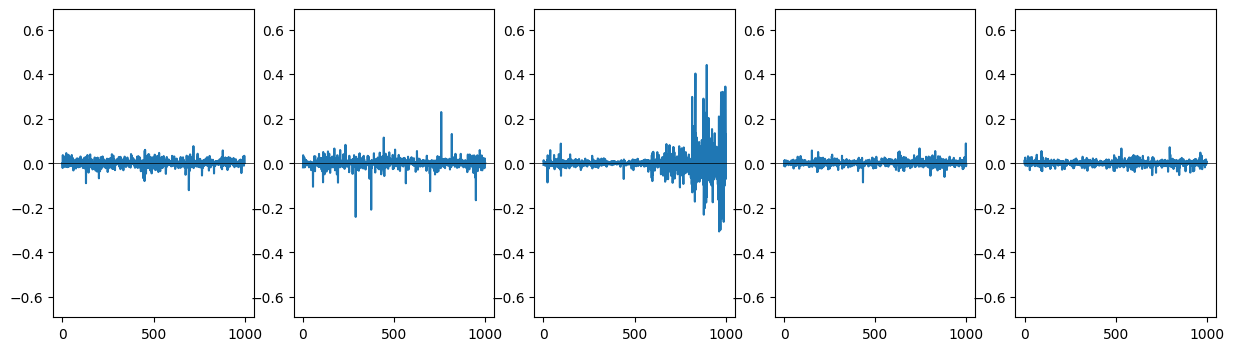

In [8]:
# Determine the y-axis limits
y_min = min(min(x) for x in X[0:50]) - 0.05
y_max = max(max(x) for x in X[0:50]) + 0.05
y_abs_max = max(abs(y_min), abs(y_max))

plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(X[i+10])
    plt.ylim(-y_abs_max, y_abs_max) 
    plt.axhline(0, color='black', linewidth=0.5) 

We can perform a cumulative sum to check how the real data is.

<Axes: >

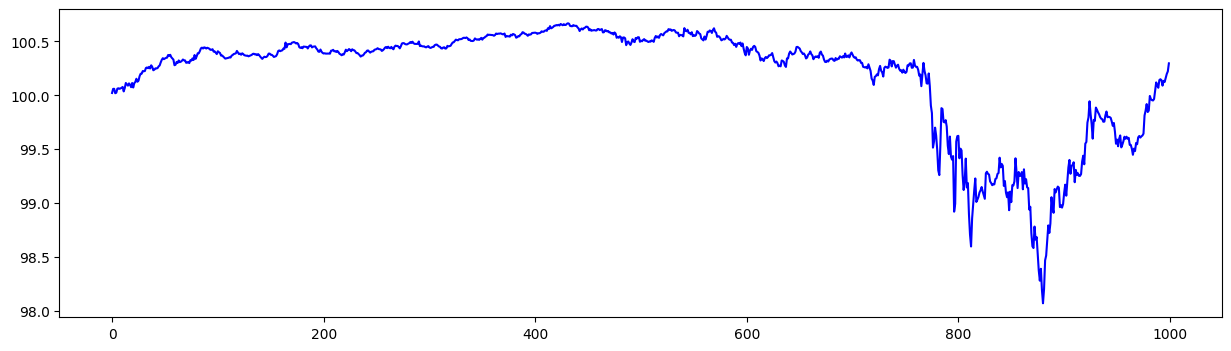

In [9]:
real_prices = np.cumsum(X, axis=1) + 100

plt.figure(figsize=(15,4))
sns.lineplot(real_prices[0], color='blue')

Function for getting the quantiles of a dataset

In [10]:
@tf.function(reduce_retracing=True)
def compute_quantiles(data, quantile_values):
    return tf.transpose( tfp.stats.percentile(data, quantile_values, interpolation='midpoint', axis=1))

quantiles = compute_quantiles(X[0:5], [25, 50, 75])
quantiles

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[-0.01145055,  0.00027664,  0.01262161],
       [-0.01617539,  0.        ,  0.01637612],
       [-0.011896  , -0.00034711,  0.01217087],
       [-0.00635085,  0.00041735,  0.00920692],
       [-0.00928469,  0.00045249,  0.00982179]])>

The values of the covariance lag.

In [11]:
@tf.function(reduce_retracing=True)
def acf_of_moments(data, max_lag):
    squared_data = tf.square(data)
    mean_squared = tf.reduce_mean(squared_data, axis=1, keepdims=True)
    variance = tf.reduce_mean((squared_data - mean_squared) ** 2, axis=1)

    acf_values = [
        tf.reduce_mean((squared_data[:, :-lag] - mean_squared) * (squared_data[:, lag:] - mean_squared), axis=1)
        for lag in range(1, max_lag + 1)
    ]
    acf_values = tf.stack(acf_values, axis=1) / tf.expand_dims(variance, axis=1)
    return acf_values


acf_values = acf_of_moments(X[0:5], max_lag=10)
acf_values

<tf.Tensor: shape=(5, 10), dtype=float64, numpy=
array([[ 1.15048563e-01,  4.29371388e-01,  2.38915730e-01,
         1.19518931e-01,  1.74820777e-01,  2.56736103e-01,
         1.54243388e-01,  2.03219011e-01,  2.01224889e-01,
         1.91514196e-01],
       [ 1.00778594e-01,  9.60654616e-02,  1.21597691e-01,
         9.48434276e-02,  1.58163733e-01,  4.74417226e-02,
         8.24380929e-02,  6.55740634e-02,  4.70759841e-02,
         5.82692750e-02],
       [ 1.56475059e-02,  1.48855608e-02, -6.64363708e-03,
         1.76943480e-03,  4.75616078e-03,  7.34975204e-07,
         8.97149065e-03,  2.77155220e-02,  1.14832825e-02,
         1.07828081e-02],
       [ 1.30636796e-02,  2.91848649e-02,  4.73007402e-02,
         8.84699304e-03, -2.16083978e-03,  4.11892462e-02,
        -1.15514023e-02, -1.04249080e-03,  4.32868020e-02,
         3.39369746e-02],
       [ 9.37347720e-02,  2.80206781e-01,  1.39160570e-01,
         1.75916767e-01,  1.04320439e-01,  1.41738303e-01,
         8.34483868e-

If data is above certain threshold set by hand

In [12]:
@tf.function(reduce_retracing=True)
def tail_probability(data, threshold=0.075):
    return tf.reduce_mean(tf.cast(tf.abs(data) > threshold, tf.float32), axis=1)


tail_prob = tail_probability(X[0:5], threshold=0.075)
tail_prob

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.102, 0.045, 0.01 , 0.005, 0.003], dtype=float32)>

The asymmetry of the values above certain threshold set by hand.

In [13]:
@tf.function(reduce_retracing=True)
def tail_asymmetry(data, threshold=0.075):
    positive_extremes = tf.reduce_sum(tf.cast(data > threshold, tf.float32), axis=1)
    negative_extremes = tf.reduce_sum(tf.cast(data < -threshold, tf.float32), axis=1)
    return positive_extremes / (negative_extremes + 1e-8)

tail_asym = tail_asymmetry(X[0:5], threshold=0.075)
tail_asym

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.04      , 0.95652175, 1.        , 0.6666667 , 2.        ],
      dtype=float32)>

In [14]:
@tf.function(reduce_retracing=True)
def rolling_std(series, window, num_volatility_points):
    # Pad the series for edge cases
    padded_series = tf.pad(series, [[0, 0], [window - 1, 0]], mode='CONSTANT')
    windows = tf.signal.frame(padded_series, frame_length=window, frame_step=1, axis=1)
    value = tf.math.reduce_std(windows, axis=2)
    # Downsample to num_volatility_points by slicing evenly
    indices = tf.cast(tf.linspace(0, tf.shape(value)[1] - 1, num=num_volatility_points), tf.int32)
    sampled_volatility = tf.gather(value, indices, axis=1)
    return sampled_volatility

rolling_window = 50
num_volatility_points = 30
rolling_volatility = rolling_std(X[0:5], window=rolling_window, num_volatility_points=num_volatility_points)
rolling_volatility

<tf.Tensor: shape=(5, 30), dtype=float64, numpy=
array([[3.09612437e-03, 2.02961765e-02, 1.99386110e-02, 1.78219262e-02,
        9.91190221e-03, 1.42002554e-02, 1.55228465e-02, 1.18108914e-02,
        1.08617965e-02, 1.15391552e-02, 8.58029334e-03, 9.02248582e-03,
        9.76524098e-03, 9.99931531e-03, 1.35658125e-02, 2.02266396e-02,
        1.80351530e-02, 2.24250258e-02, 2.47067644e-02, 2.39121587e-02,
        1.92798414e-02, 2.33365625e-02, 3.34101822e-02, 1.07723650e-01,
        1.79032024e-01, 1.05130916e-01, 1.30150499e-01, 1.07178752e-01,
        7.32479456e-02, 5.12261504e-02],
       [5.37634409e-04, 3.10971520e-02, 1.97374941e-02, 2.08938781e-02,
        2.15361093e-02, 1.75229187e-02, 1.81102523e-02, 1.62763929e-02,
        2.61770758e-02, 3.60179302e-02, 5.13005820e-02, 3.39594369e-02,
        4.32521668e-02, 3.15363841e-02, 3.03080393e-02, 4.07765423e-02,
        4.78351274e-02, 7.08180104e-02, 5.63545525e-02, 3.92355805e-02,
        3.86344794e-02, 3.14415780e-02, 3.1329

Broadcasting means expanding to a dimension a vector of no dimension, so it can be replicated to the size of another vector when doing operations between them (or something like this)

In [15]:
@tf.function(reduce_retracing=True)
def compute_GMM(X, threshold_tail_asym = 0.075, threshold_tail_prob = 0.075):
    X = tf.cast(X, tf.float32)
    
    mean = tf.reduce_mean(X, axis=1)
    std = tf.math.reduce_std(X, axis=1)
    std_window = rolling_std(X, window=50, num_volatility_points=20)
    mean_exp = tf.expand_dims(mean, axis=1)
    
    skewness = tf.reduce_mean((X - mean_exp) ** 3, axis=1) / (std ** 3)
    kurtosis = tf.reduce_mean((X - mean_exp) ** 4, axis=1) / (std ** 4) - 3
    
    # Compute autocorrelations and quantiles
    acf_values = acf_of_moments(X, max_lag=10)
    acf_values_abs = acf_of_moments(tf.abs(X), max_lag=20)
    quantiles = compute_quantiles(X, [1, 5, 10, 25, 40, 50, 60, 75, 90, 95, 99])
    tail_asym = tail_asymmetry(X, threshold=threshold_tail_asym)
    tail_prob = tail_probability(X, threshold=threshold_tail_prob)
    
    scalar_stats = tf.stack([mean, std, skewness, kurtosis, tail_asym, tail_prob], axis=1)
    return tf.concat([scalar_stats, std_window, quantiles, acf_values, acf_values_abs], axis=1)


Setting the input dimension of the GMM

In [16]:
num_GMMs=compute_GMM(X[0:5]).shape[1]
print("Number of ouputs of the GMM: ", num_GMMs)

Number of ouputs of the GMM:  67


In [17]:
import tensorflow.keras.backend as K

def relativistic_average(input_):
    x_0 = input_[0]
    x_1 = input_[1]
    return x_0 - K.mean(x_1, axis=0)

LOSS='binary_crossentropy'
#OPT = tf.keras.optimizers.Adam(learning_rate=INIT_LR, beta_1=0.8, beta_2=0.995)


OPT_gen = tf.keras.optimizers.Adam(learning_rate=INIT_LR, beta_1=0.8, beta_2=0.995)
OPT_disc = tf.keras.optimizers.Adam(learning_rate=INIT_LR, beta_1=0.8, beta_2=0.995)

In [19]:
from keras.layers import Lambda
from tensorflow.keras.layers import PReLU


def generator_builder(T,dim_noise,activation="relu",use_bias=True):
    ## FILL THIS !!!
    
    def residual_block(x, units):
        shortcut = x
        x = Dense(units, activation=activation, use_bias=use_bias)(x)
        x = Dense(units, activation=activation, use_bias=use_bias)(x)
        return x + shortcut   
    
    input_layer = Input(shape=(dim_noise,))
    x = Dense(dim_noise // 2, activation=activation, use_bias=use_bias)(input_layer)
    x = residual_block(x, dim_noise  // 2)
    x = Dense(dim_noise // 4, activation=activation, use_bias=use_bias)(x)
    x = residual_block(x, dim_noise  // 4)
    x = Dense(T, activation='linear', use_bias=use_bias)(x)
    gen = Model(inputs=input_layer, outputs=x)
    return gen


def discriminator_builder(num_GMMs, T, activation="relu", use_bias=True):
    ## Call compute_GMM
    input_layer = Input(shape=(T,))
    gmm_features = Lambda(compute_GMM, output_shape=(num_GMMs,))(input_layer)

    x = Dense(num_GMMs, use_bias=use_bias)(gmm_features)
    x = PReLU()(x)
    x = Dense(num_GMMs, use_bias=use_bias)(x)
    x = PReLU()(x)
    x = Dense(num_GMMs, use_bias=use_bias)(x)
    x = PReLU()(x)
    x = Dense(num_GMMs // 2, use_bias=use_bias)(x)
    x = PReLU()(x)
    x = Dense(num_GMMs // 4, use_bias=use_bias)(x)
    x = PReLU()(x)

    y = Dense(T // 4, use_bias=use_bias)(input_layer)
    y = PReLU()(y)
    y = Dense(T // 20, use_bias=use_bias)(y)
    y = PReLU()(y)
    y = Dense(T // 50, use_bias=use_bias)(y)
    y = PReLU()(y)
    y = Dense(T // 100, use_bias=use_bias)(y)
    y = PReLU()(y)

    z = Concatenate()([x, y])
    z = Dense(32, use_bias=use_bias)(z)
    z = PReLU()(z)
    z = Dense(16, use_bias=use_bias)(z)
    z = PReLU()(z)
    z = Dense(8, use_bias=use_bias)(z)
    z = PReLU()(z)
    z = Dense(1, activation='sigmoid', use_bias=use_bias)(z)

    disc = Model(inputs=input_layer, outputs=z)
    return disc


discriminator=discriminator_builder(num_GMMs,T,use_bias=bias,activation=activation_discriminator)
generator    =generator_builder(T,dim_noise,use_bias=bias,activation=activation_generator)

In [20]:
discriminator.compile(OPT_disc, loss=LOSS)
discriminator.build(input_shape=(2*batch_size,T))
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 67)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 67)        │      4,489 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 67)        │         67 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 67)        │      4,489 │ p_re_lu[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 250)       │    250,000 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 67)        │         67 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 250)       │        250 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 67)        │      4,489 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50)        │     12,500 │ p_re_lu_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 67)        │         67 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_6 (PReLU)   │ (None, 50)        │         50 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 33)        │      2,211 │ p_re_lu_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20)        │      1,000 │ p_re_lu_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 33)        │         33 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_7 (PReLU)   │ (None, 20)        │         20 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ p_re_lu_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        200 │ p_re_lu_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 16)        │         16 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_8 (PReLU)   │ (None, 10)        │         10 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26)        │          0 │ p_re_lu_4[0][0],  │
│ (Concatenate)       │                   │            │ p_re_lu_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_9 (PReLU)   │ (None, 32)        │         32 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        512 │ p_re_lu_9[0][0] 

 Total params: 282,022 (1.08 MB)

 Trainable params: 282,022 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

Real_data                          = Input(shape=X.shape[1:])
Noise_input                        = Input(shape=(dim_noise,))

Fake_data                          = generator(Noise_input)
Discriminator_real_out             = discriminator(Real_data)
Discriminator_fake_out             = discriminator(Fake_data)
Real_Fake_relativistic_average_out = Lambda(relativistic_average, name='Real_minus_mean_fake')([Discriminator_real_out, Discriminator_fake_out])
Fake_Real_relativistic_average_out = Lambda(relativistic_average, name='Fake_minus_mean_real')([Discriminator_fake_out, Discriminator_real_out])

Real_Fake_relativistic_average_out = Activation('sigmoid')(Real_Fake_relativistic_average_out)
Fake_Real_relativistic_average_out = Activation('sigmoid')(Fake_Real_relativistic_average_out)

In [22]:
Discriminator_Relativistic_out = Concatenate()([Real_Fake_relativistic_average_out, Fake_Real_relativistic_average_out])

generator_train = Model([Noise_input, Real_data], Discriminator_Relativistic_out)
discriminator.trainable=False
generator_train.compile(OPT_gen, loss=LOSS)
generator_train.summary()
#SVG(model_to_dot(generator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1000)      │ 32,500,000 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │    282,022 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Real_minus_mean_fa… │ (None, 1)         │          0 │ functional[0][0], │
│ (Lambda)            │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fake_minus_mean_re… │ (None, 1)         │          0 │ functional[1][0], │
│ (Lambda)            │                   │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ Real_minus_mean_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ Fake_minus_mean_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ activation_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,782,022 (125.05 MB)

 Trainable params: 32,500,000 (123.98 MB)

 Non-trainable params: 282,022 (1.08 MB)

In [23]:
discriminator_train = Model([Noise_input, Real_data],Discriminator_Relativistic_out)
generator.trainable = False
discriminator.trainable=True
discriminator_train.summary()
discriminator_train.compile(OPT_disc, loss=LOSS)
#SVG(model_to_dot(discriminator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1000)      │ 32,500,000 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │    282,022 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Real_minus_mean_fa… │ (None, 1)         │          0 │ functional[0][0], │
│ (Lambda)            │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fake_minus_mean_re… │ (None, 1)         │          0 │ functional[1][0], │
│ (Lambda)            │                   │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ Real_minus_mean_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ Fake_minus_mean_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ activation_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,782,022 (125.05 MB)

 Trainable params: 282,022 (1.08 MB)

 Non-trainable params: 32,500,000 (123.98 MB)

In [24]:
true_y = np.ones((batch_size, 1), dtype=np.float32)
true_y = tf.convert_to_tensor(true_y, dtype=tf.float32)
fake_y = np.zeros((batch_size, 1), dtype=np.float32)
fake_y = tf.convert_to_tensor(fake_y, dtype=tf.float32)
y_for_dis = np.concatenate((true_y, fake_y), axis=1)
y_for_dis = tf.convert_to_tensor(y_for_dis, dtype=tf.float32)
y_for_gen = np.concatenate((fake_y, true_y), axis=1)
y_for_gen = tf.convert_to_tensor(y_for_gen, dtype=tf.float32)



TRAINING_RATIO=1

discriminator_loss=[]
generator_loss=[]

In [25]:
def train_discriminator_step(noise, data_batch, y_for_dis):
    discriminator.trainable = True
    generator.trainable = False
    value =  discriminator_train.train_on_batch([noise, data_batch], y_for_dis)
    return value

def train_generator_step(noise, data_batch, y_for_gen):
    discriminator.trainable = False
    generator.trainable = True
    value =  generator_train.train_on_batch([noise, data_batch], y_for_gen)
    return value

noise_tensor = tf.Variable(tf.zeros([batch_size, dim_noise], dtype=tf.float32))
data_tensor = tf.Variable(tf.zeros([batch_size, T], dtype=tf.float32))

for epoch in range(num_epochs):
    
    discriminator_loss_epoch = [] 
    generator_loss_epoch = []
    
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, num_epochs))
    num_batches = int(X.shape[0] // batch_size)
    minibatches_size = batch_size * (TRAINING_RATIO+1)
    print("number of batches: {}".format(int(X.shape[0] // (minibatches_size))))
    print("minibatches_size: "+str(minibatches_size))
    print("num_batches "+str(num_batches))
    
    progress_bar = Progbar(target=int(X.shape[0] // minibatches_size))

    start_time = time()
    for index in range(int(X.shape[0] // (minibatches_size))):
        progress_bar.update(index)
        iteration_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]

        for j in range(TRAINING_RATIO):
            data_batch = iteration_minibatches[j * batch_size : (j + 1) * batch_size]
            noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
            
            noise_tensor.assign(noise)
            data_tensor.assign(data_batch)
            
            value = train_discriminator_step(noise, data_batch, y_for_dis)
            discriminator_loss_epoch.append(value)
            
        data_batch = iteration_minibatches[TRAINING_RATIO*batch_size : (TRAINING_RATIO + 1) * batch_size]
        noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
        
        noise_tensor.assign(noise)
        data_tensor.assign(data_batch)
        
        value = train_generator_step(noise, data_batch, y_for_gen)
        generator_loss_epoch.append(value)

    print('\nepoch time: {}'.format(time()-start_time))
    
    test_noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
    test_noise = tf.convert_to_tensor(test_noise, dtype=tf.float32)
    
    
    discriminator_loss.append(np.mean(discriminator_loss_epoch))
    generator_loss.append(np.mean(generator_loss_epoch))
    
    del discriminator_loss_epoch
    del generator_loss_epoch
 

epoch 1 of 500
number of batches: 100
minibatches_size: 100
num_batches 200
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step  WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x000001E75E518040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
 99/100 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
epoch time: 411.9941382408142
epoch 2 of 500
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 ━━━━━━━━━━━

KeyboardInterrupt: 

In [26]:
discriminator.save_weights("discriminator.weights.h5")
generator.save_weights("generator.weights.h5")

In [27]:
discriminator_loss_np = np.array(discriminator_loss)
generator_loss_np = np.array(generator_loss)

## Tracer les pertes de generateur et discriminateur

<Axes: >

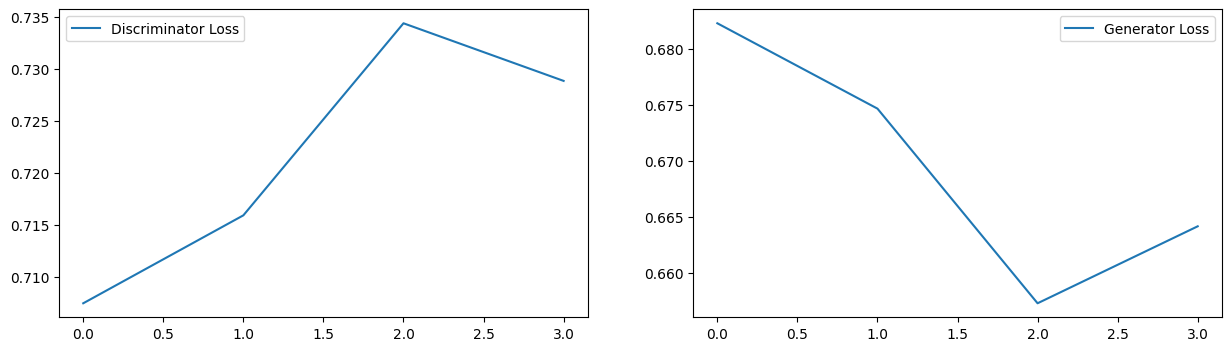

In [28]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.lineplot(data=discriminator_loss_np, label='Discriminator Loss')
plt.subplot(1,2,2)
sns.lineplot(data = generator_loss_np, label='Generator Loss')


The model takes too long to run. 3 epochs took almost 1 hour.

## Generate many time series and compare them with real time series

In [29]:
amount = 1000
noise = np.random.standard_t(nu,size=(amount, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
generated_returns = generator.predict(noise)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Lets say that the initial price was 100

In [30]:
initial_price = 100
fake_prices = initial_price + np.cumsum(generated_returns, axis=1)

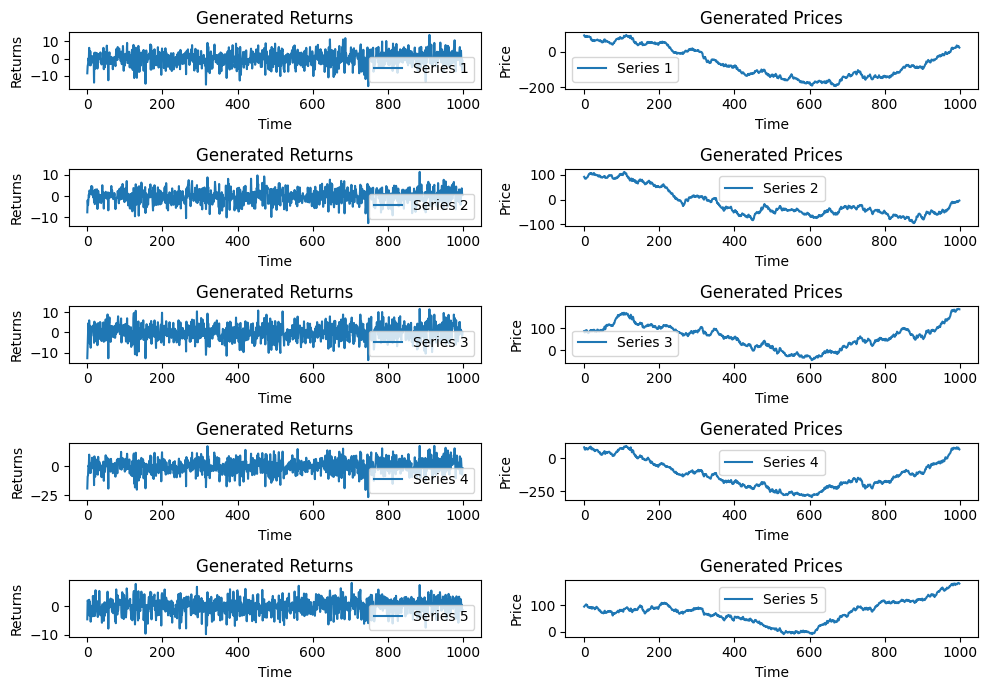

In [31]:
n_series = 5

fig, axes = plt.subplots(n_series, 2, figsize=(10, int(n_series * 1.5)))

for i in range(n_series):
    axes[i, 0].plot(generated_returns[i], label=f"Series {i+1}")
    axes[i, 0].set_title("Generated Returns")
    axes[i, 0].set_xlabel("Time")
    axes[i, 0].set_ylabel("Returns")
    axes[i, 0].legend()
    
    axes[i, 1].plot(fake_prices[i], label=f"Series {i+1}")
    axes[i, 1].set_title("Generated Prices")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Price")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

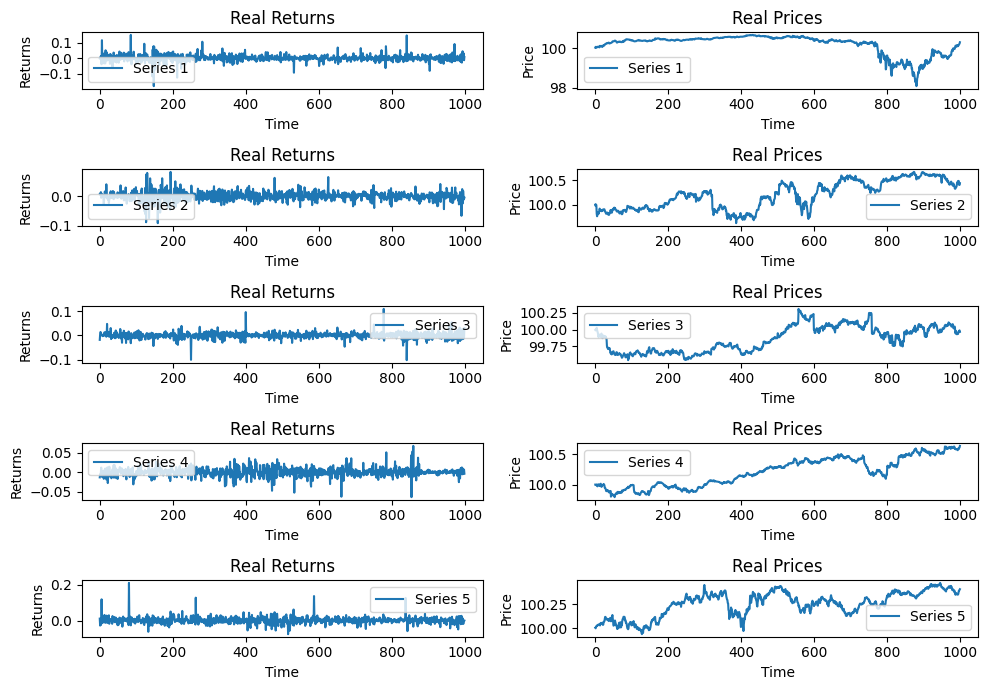

In [32]:
n_series = 5

fig, axes = plt.subplots(n_series, 2, figsize=(10, int(n_series * 1.5)))

for i in range(n_series):
    axes[i, 0].plot(X[i], label=f"Series {i+1}")
    axes[i, 0].set_title("Real Returns")
    axes[i, 0].set_xlabel("Time")
    axes[i, 0].set_ylabel("Returns")
    axes[i, 0].legend()
    
    axes[i, 1].plot(real_prices[i], label=f"Series {i+1}")
    axes[i, 1].set_title("Real Prices")
    axes[i, 1].set_xlabel("Time")
    axes[i, 1].set_ylabel("Price")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

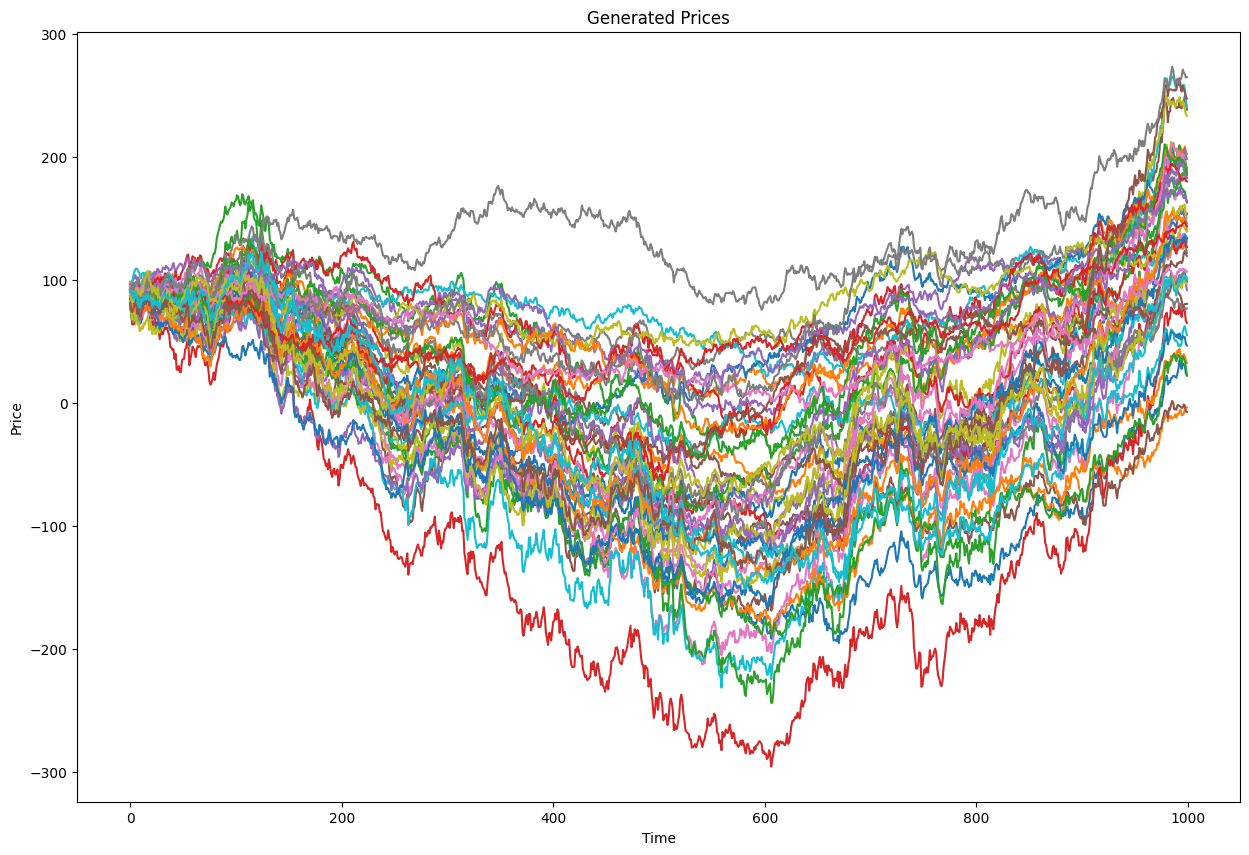

In [33]:
n_series = 50

plt.figure(figsize=(15, 10))

for i in range(n_series):
    plt.plot(fake_prices[i], label=f"Series {i+1}")

plt.title("Generated Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

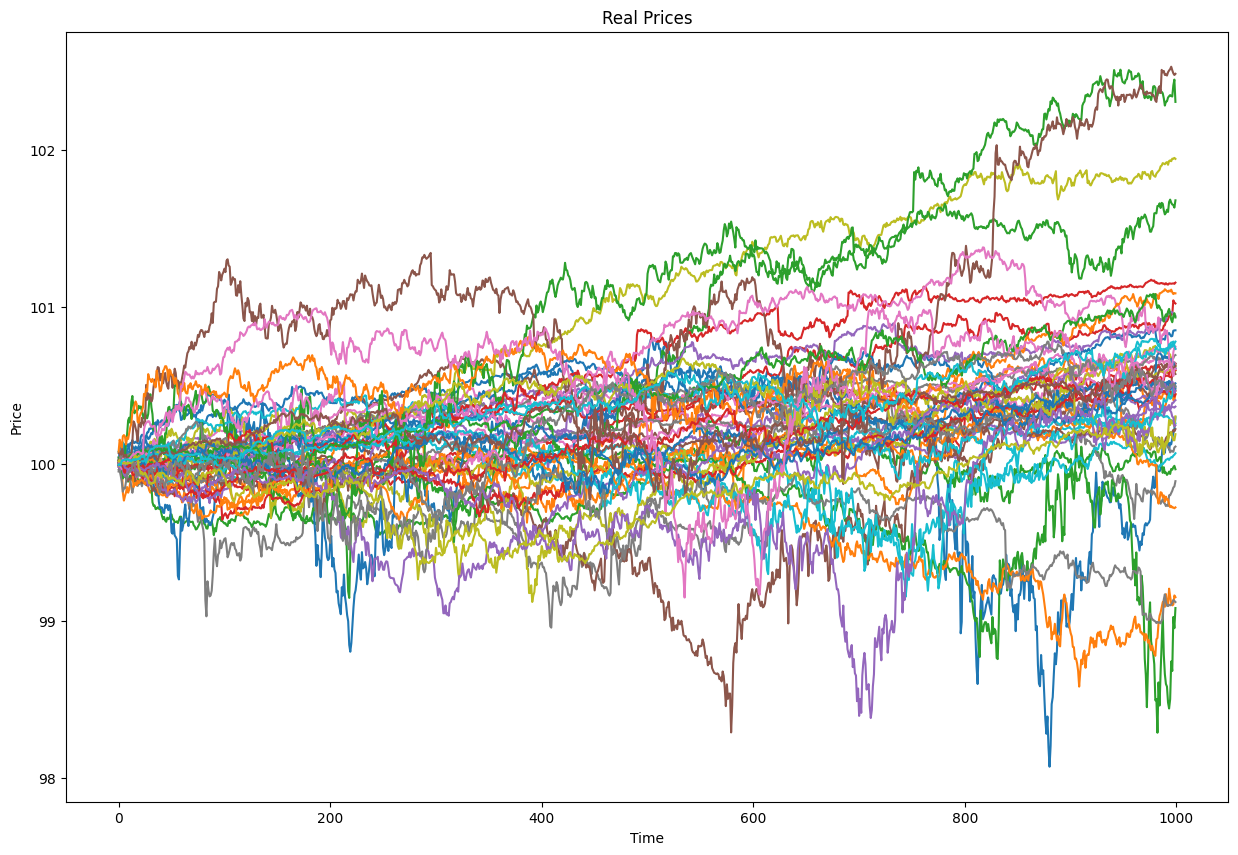

In [35]:
n_series = 50

plt.figure(figsize=(15, 10))

for i in range(n_series):
    plt.plot(real_prices[i], label=f"Series {i+1}")

plt.title("Real Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

We can see that the time series generated by the GAN resembles more the real data, than the gan from the previous TP. However, until this moment, the GAN is not giving a satisfactory result. Some values are able to reach the negative values. From what I can conclude from the graphs, is that the model didn't learn well the magnitud, amplitud of the data. The shape of the time series is more similar to a real time series of returns than the GAN from TP-3, but the values are not well learned. That is why i thought of addying to the discriminator a measure of volatilty of different points inside the time series. However, after doing this, the fake results had a tendency to be more negative than the real data. So, to improve the model, for next time we need to make sure the model is able to capture the magnitud of the data.

## Checking for faits stylized

### Lagged Correlation

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

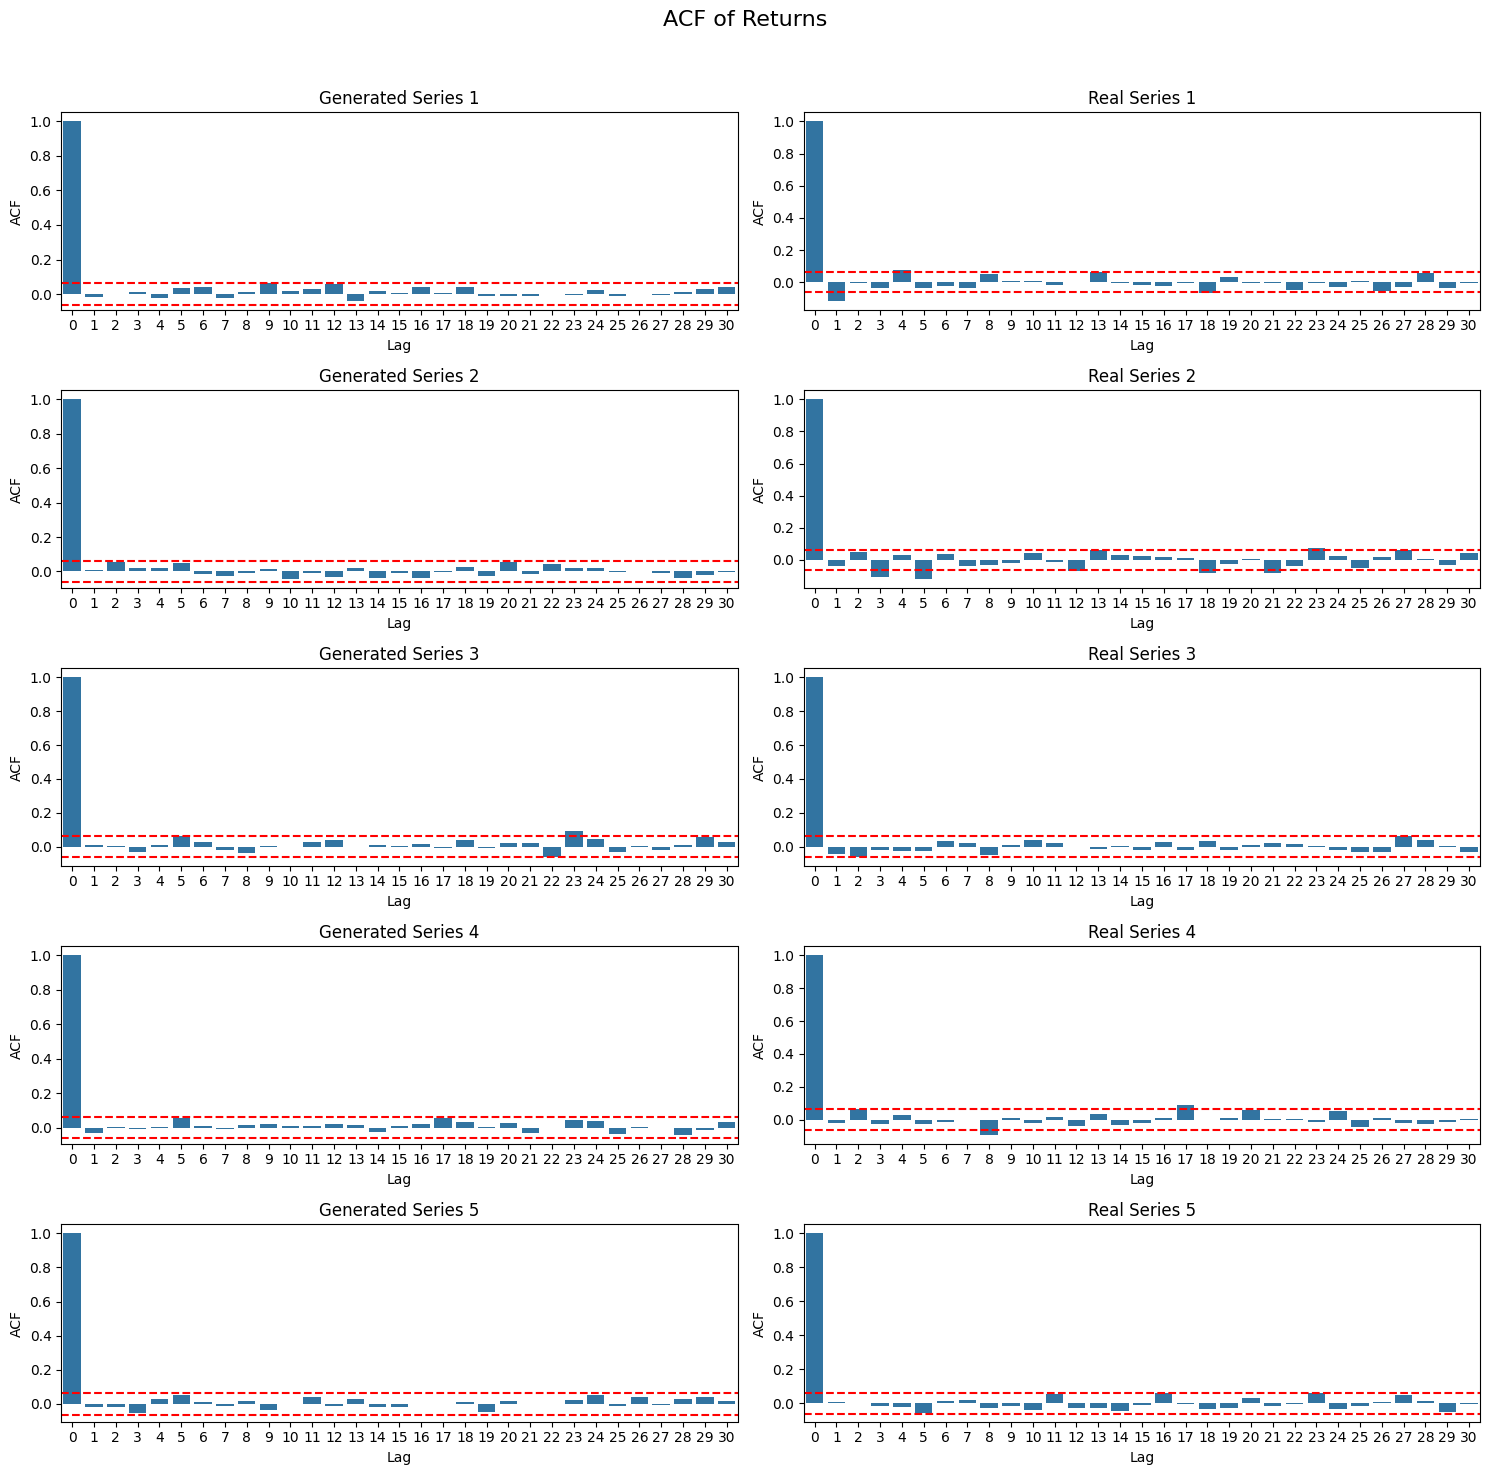

In [39]:
n_series = 5
num_points = len(generated_returns[0])  # Number of points in each time series
conf_interval = 1.96 / np.sqrt(num_points)  # 95% confidence interval

plt.figure(figsize=(15, 15))
plt.suptitle("ACF of Returns", fontsize=16)
for i in range(n_series):
    plt.subplot(n_series, 2, 2 * i+1)
    acf_values = acf(generated_returns[i])
    sns.barplot(x=list(range(len(acf_values))), y=acf_values)
    plt.axhline(conf_interval, color='red', linestyle='--', label='95% CI')
    plt.axhline(-conf_interval, color='red', linestyle='--')
    plt.title(f"Generated Series {i+1}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
    
    plt.subplot(n_series, 2, 2 * i+2)
    acf_values = acf(X[i])
    sns.barplot(x=list(range(len(acf_values))), y=acf_values)
    plt.axhline(conf_interval, color='red', linestyle='--', label='95% CI')
    plt.axhline(-conf_interval, color='red', linestyle='--')
    plt.title(f"Real Series {i+1}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title

plt.show()

We know that real time series do not have correlation with lagged values. So, we can check if the time series generated by the GAN has correlation with lagged values. If it has, then the model is not well learned. In inspecting the graphs, we can see that there is no correlation with lagged values. So, the model is well learned in this aspect.

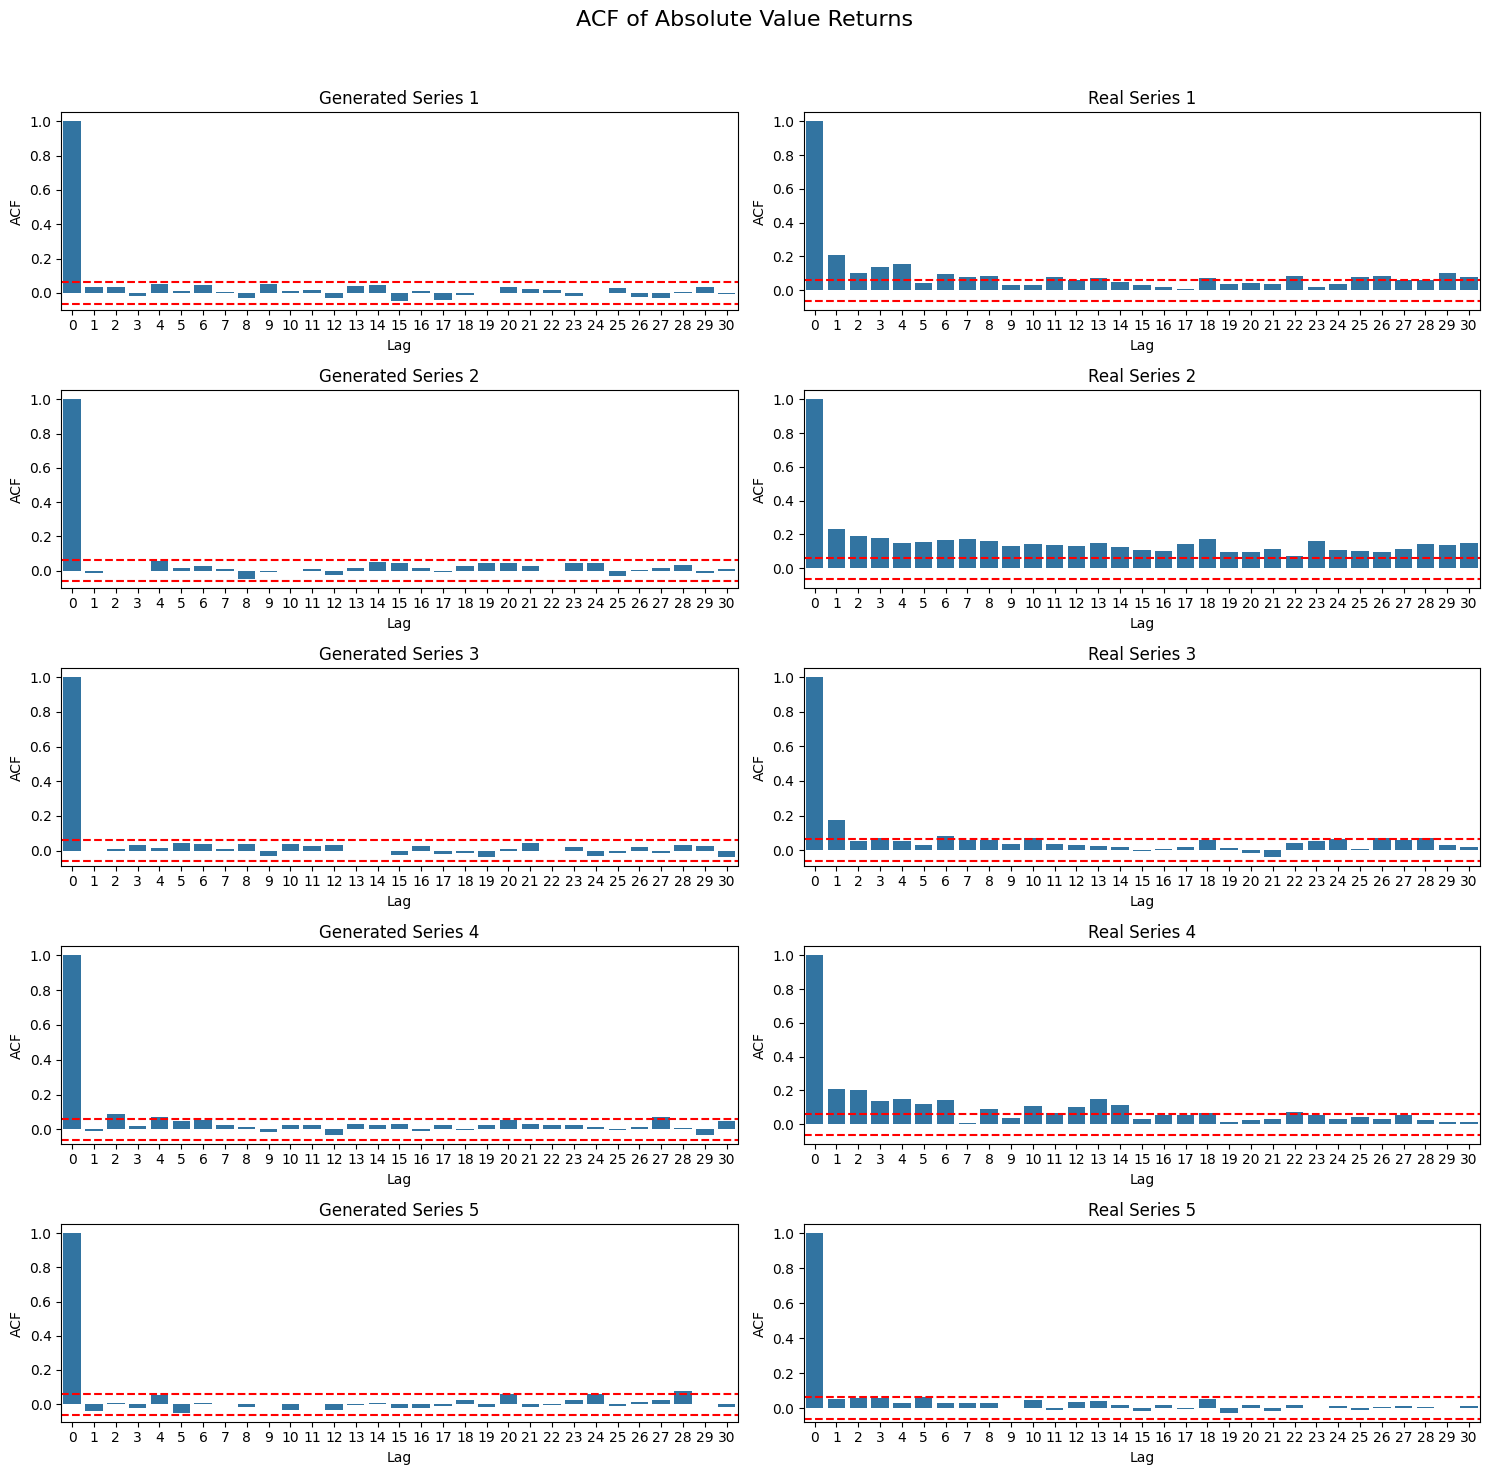

In [40]:
n_series = 5
num_points = len(generated_returns[0])  # Number of points in each time series
conf_interval = 1.96 / np.sqrt(num_points)  # 95% confidence interval

plt.figure(figsize=(15, 15))
plt.suptitle("ACF of Absolute Value Returns", fontsize=16)
for i in range(n_series):
    plt.subplot(n_series, 2, 2 * i+1)
    acf_values = acf(np.abs(generated_returns[i]))
    sns.barplot(x=list(range(len(acf_values))), y=acf_values)
    plt.axhline(conf_interval, color='red', linestyle='--', label='95% CI')
    plt.axhline(-conf_interval, color='red', linestyle='--')
    plt.title(f"Generated Series {i+1}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
    
    plt.subplot(n_series, 2, 2 * i+2)
    acf_values = acf(np.abs(X[i]))
    sns.barplot(x=list(range(len(acf_values))), y=acf_values)
    plt.axhline(conf_interval, color='red', linestyle='--', label='95% CI')
    plt.axhline(-conf_interval, color='red', linestyle='--')
    plt.title(f"Real Series {i+1}")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title

plt.show()

We know that real time series have long memory, which can be represented by the lag correlation of the absolute values of the time serie. This correlation should tend to 0 as the lag increases. We can see by inspection that the time series generated by the GAN doesn't have this property. So, the model is not well learned in this aspect.

### Checking for heavy tails

In [41]:
from scipy.stats import norm, cauchy, pareto

In [42]:
real_volatility = np.std(rets)
real_sorted_returns = np.sort(rets)
real_ccdf = 1.0 - np.arange(1, len(real_sorted_returns) + 1) / len(real_sorted_returns)

In [43]:
fake_volatility = np.std( generated_returns.flatten())
fake_sorted_returns = np.sort(generated_returns.flatten())
fake_ccdf = 1.0 - np.arange(1, len(fake_sorted_returns) + 1) / len(fake_sorted_returns)

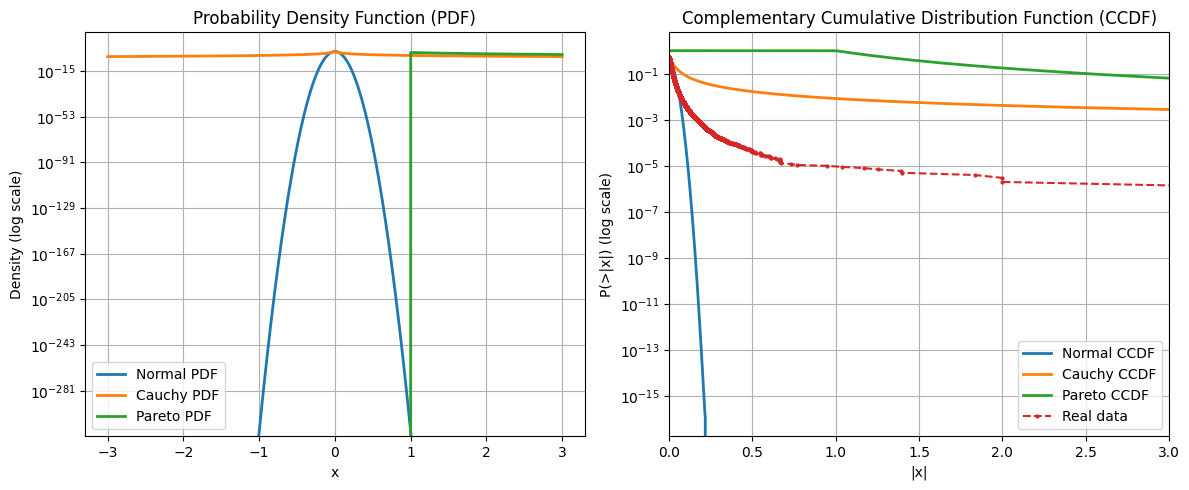

In [44]:
x_max_value = 3
x = np.linspace(-x_max_value, x_max_value, 1000)  # Range for PDF
x_positive = np.linspace(0.01, x_max_value, 1000)  # Positive range for CCDF

# Normal distribution
normal_pdf = norm.pdf(x, loc=0, scale=real_volatility)
normal_ccdf = 1 - norm.cdf(x_positive, loc=0, scale=real_volatility)

# Cauchy distribution (heavy-tailed)
cauchy_pdf = cauchy.pdf(x, loc=0, scale=real_volatility)
cauchy_ccdf = 1 - cauchy.cdf(x_positive, loc=0, scale=real_volatility)

# Pareto distribution (heavy-tailed)
pareto_b = 2.5  # Shape parameter for Pareto (controls tail heaviness)
pareto_pdf = pareto.pdf(x_positive, b=pareto_b)
pareto_ccdf = 1 - pareto.cdf(x_positive, b=pareto_b)

# Plot PDFs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, normal_pdf, label='Normal PDF', lw=2)
plt.plot(x, cauchy_pdf, label='Cauchy PDF', lw=2)
plt.plot(x_positive, pareto_pdf, label='Pareto PDF', lw=2)
plt.yscale('log')  # Log scale for PDF comparison
plt.title('Probability Density Function (PDF)')
plt.xlabel('x')
plt.ylabel('Density (log scale)')
plt.legend()
plt.grid(True)

# Plot CCDFs
plt.subplot(1, 2, 2)
plt.plot(x_positive, normal_ccdf, label='Normal CCDF', lw=2)
plt.plot(x_positive, cauchy_ccdf, label='Cauchy CCDF', lw=2)
plt.plot(x_positive, pareto_ccdf, label='Pareto CCDF', lw=2)
plt.plot(real_sorted_returns, real_ccdf, marker='o', linestyle='--', markersize=2, label='Real data')
plt.yscale('log')  # Log scale for CCDF
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.xlabel('|x|')
plt.xlim(0,x_max_value)
plt.ylabel('P(>|x|) (log scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


We are going to check if the time series have heavy tails if the time series generated by the GAN has a higher probability of the complementary cumulative distribution function than the normal distribution. This means, that for a bigger |x|, the probability of a point being bigger should be higher than the normal distribution. We can see that the time series of the real data is heavier than the normal distribution. I also added another heavy tail distributions for comparison. Cauchy distribution has a density function decay as $x^{-2}$. Pareto distribution has a decay of the order $x^{-(\alpha + 1)}$

\begin{equation}
    CCDF(x) = 1 - CDF(x) = P(X > x)
\end{equation}

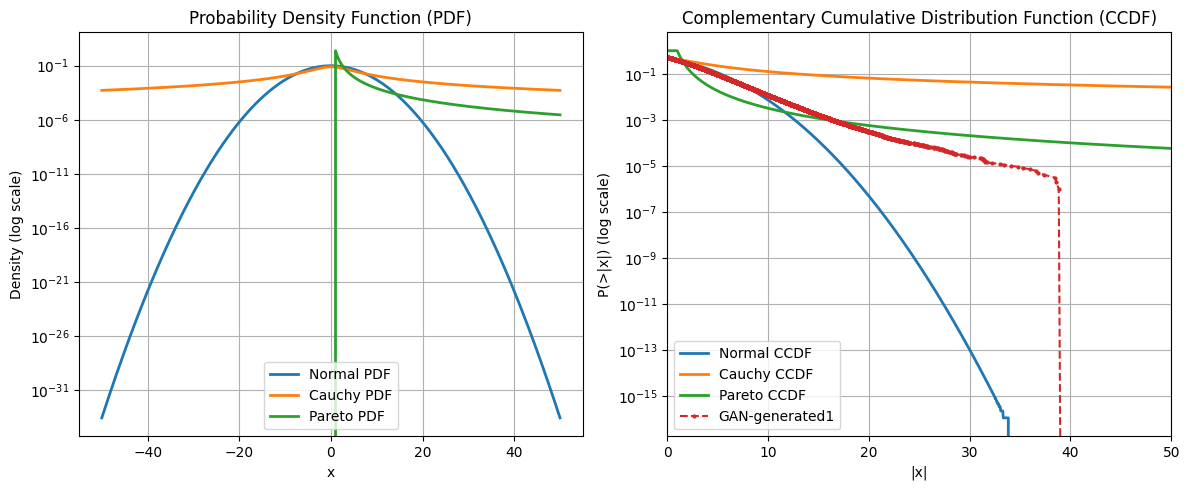

In [49]:
x_max_value = 50
x = np.linspace(-x_max_value, x_max_value, 1000)  # Range for PDF
x_positive = np.linspace(0.01, x_max_value, 1000)  # Positive range for CCDF

# Normal distribution
normal_pdf = norm.pdf(x, loc=0, scale=fake_volatility)
normal_ccdf = 1 - norm.cdf(x_positive, loc=0, scale=fake_volatility)

# Cauchy distribution (heavy-tailed)
cauchy_pdf = cauchy.pdf(x, loc=0, scale=fake_volatility)
cauchy_ccdf = 1 - cauchy.cdf(x_positive, loc=0, scale=fake_volatility)

# Pareto distribution (heavy-tailed)
pareto_b = 2.5  # Shape parameter for Pareto (controls tail heaviness)
pareto_pdf = pareto.pdf(x_positive, b=pareto_b)
pareto_ccdf = 1 - pareto.cdf(x_positive, b=pareto_b)

# Plot PDFs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, normal_pdf, label='Normal PDF', lw=2)
plt.plot(x, cauchy_pdf, label='Cauchy PDF', lw=2)
plt.plot(x_positive, pareto_pdf, label='Pareto PDF', lw=2)
plt.yscale('log')  # Log scale for PDF comparison
plt.title('Probability Density Function (PDF)')
plt.xlabel('x')
plt.ylabel('Density (log scale)')
plt.legend()
plt.grid(True)

# Plot CCDFs
plt.subplot(1, 2, 2)
plt.plot(x_positive, normal_ccdf, label='Normal CCDF', lw=2)
plt.plot(x_positive, cauchy_ccdf, label='Cauchy CCDF', lw=2)
plt.plot(x_positive, pareto_ccdf, label='Pareto CCDF', lw=2)
plt.plot(fake_sorted_returns, fake_ccdf, marker='o', linestyle='--', markersize=2, label='GAN-generated1')
plt.yscale('log')  # Log scale for CCDF
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.xlabel('|x|')
plt.xlim(0,x_max_value)
plt.ylabel('P(>|x|) (log scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The time series generated by the GAN has a higher probability of the complementary cumulative distribution function than the normal distribution. So, the model is well learned in this aspect. Which is a great improvement because in TP-3 we weren't able to generate heavy tails.

### Comparing mean and std

In [53]:
population_mean = round(np.mean(rets), 5)
population_std = round(np.std(rets), 4)
print("Population mean: ", population_mean)
print("Population std: ", population_std)

Population mean:  0.00054
Population std:  0.0262


In [54]:
flattened_returns = generated_returns.flatten()
sample_mean = round(np.mean(flattened_returns), 5)
sample_std = round(np.std(flattened_returns), 4)
print("Sample mean: ", sample_mean)
print("Sample std: ", sample_std)

Sample mean:  0.04817
Sample std:  4.0837


In [55]:
mu_error = np.abs(sample_mean - population_mean) / population_mean * 100
var_error = np.abs(sample_std - population_std) / population_std * 100

print(f"The error of the average is: {mu_error:.2f}% and the error of the variance is {var_error:.2f}%")

The error of the average is: 8820.37% and the error of the variance is 15486.64%


As mentioned before, we are having a problem of scaling. This can be clearly be seen by the off value of the standard deviation. For the future, we need the model to focus more in this parameter.

### Quantiles

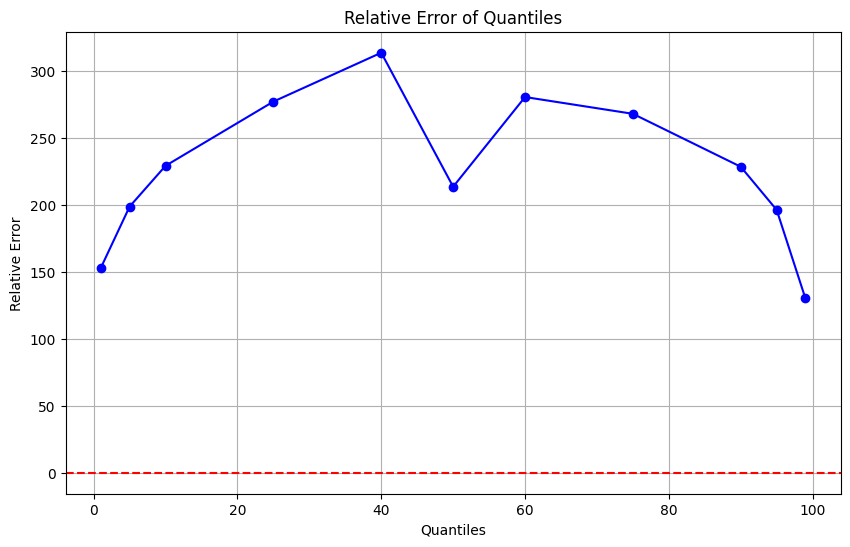

In [57]:
quantiles = [1, 5, 10, 25, 40, 50, 60, 75, 90, 95, 99]
population_quantiles = tfp.stats.percentile(rets, quantiles, interpolation='midpoint').numpy()

sample_quantiles = tf.transpose(tfp.stats.percentile(generated_returns, quantiles, interpolation='midpoint', axis=1)).numpy()
sample_quantiles = np.mean(sample_quantiles, axis=0)

# Calculate relative error
relative_error = (sample_quantiles - population_quantiles) / population_quantiles

# Plot the relative error
plt.figure(figsize=(10, 6))
plt.plot(quantiles, relative_error, marker='o', linestyle='-', color='b')
plt.axhline(0, color='r', linestyle='--')
plt.title('Relative Error of Quantiles')
plt.xlabel('Quantiles')
plt.ylabel('Relative Error')
plt.grid(True)
plt.show()

The quantiles are not fitting correspondingly to the real data, so the GAN is not able to generate the data as it should be. This, again, is a problem of scaling.

## Conclusion

The relativistic GAN has given us a new tool, which is to create time series with heavy tails. And with the use of the GMM, we were able to generate time series that resemble more the real data. However, the model still didn't learn it should had learn to have a satisfactory result. The model is not able to generate the data with the correct scaling. So, for the future, we need to focus more on this parameter (there is a high chance that I miss something important surrounding this topic).

Another important point, is the expensiveness of the model. The model took almost 1 hour to run 3 epochs. So, we need to find a way to make the model run faster. Since we are trying to generate fake time series, we cannot expect to have a simple model, but on the contrary, a very complex model. This clearly is a problem, because we need to find a balance between the complexity of the model and the time it takes to run.

### Question 7 

Not necessarily. The model might have a reduction of losses, but it might be due to artificial reasons. That is why, it is important to check afterwards if the data closely resembles the real data, and if the faits stylized are present.